In [58]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [76]:
RUN='2021-11-15-23:23:37--4c17bbc5ac71c49eb2e1d613204860e1c0986a5d'
CSV_PATH='results/'+RUN
COALESCED_NAME = 'malloc_coalesced.csv'
NON_COALESCED_NAME = 'malloc_non_coalesced.csv'
BY_BLOCK=True

In [80]:
header=['ints', 'num_blocks', 'num_threads', 'time', 'alloc_failures']
c = pd.read_csv(CSV_PATH+'/'+COALESCED_NAME, names=header, delimiter=' ')
nc = pd.read_csv(CSV_PATH+'/'+NON_COALESCED_NAME, names=header, delimiter=' ')

In [81]:
settings=['ints', 'num_blocks', 'num_threads']
header=['ints', 'num_blocks', 'num_threads', 'time_mean', 'time_std', 'alloc_failures_mean', 'alloc_failures_std']
#c = c.sort_values(settings)
#nc = nc.sort_values(settings)
c = c.groupby(settings, as_index=False).agg({'time':['mean','std'], 'alloc_failures':['mean', 'std']})
c.columns = header
nc = nc.groupby(settings, as_index=False).agg({'time':['mean','std'], 'alloc_failures':['mean', 'std']})
nc.columns = header

In [82]:
comp_time = settings + ['time_mean']
comp_failures = settings + ['alloc_failures_mean']
comp = pd.merge(c[comp_time], nc[comp_time], on=settings, how='inner')
comp['speed_up'] = comp['time_mean_y']/comp['time_mean_x']
comp.drop(labels=['time_mean_y', 'time_mean_x'], axis=1, inplace=True)

In [83]:
threads = list(c['num_threads'].unique())
blocks = list(c['num_blocks'].unique())

In [ ]:
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

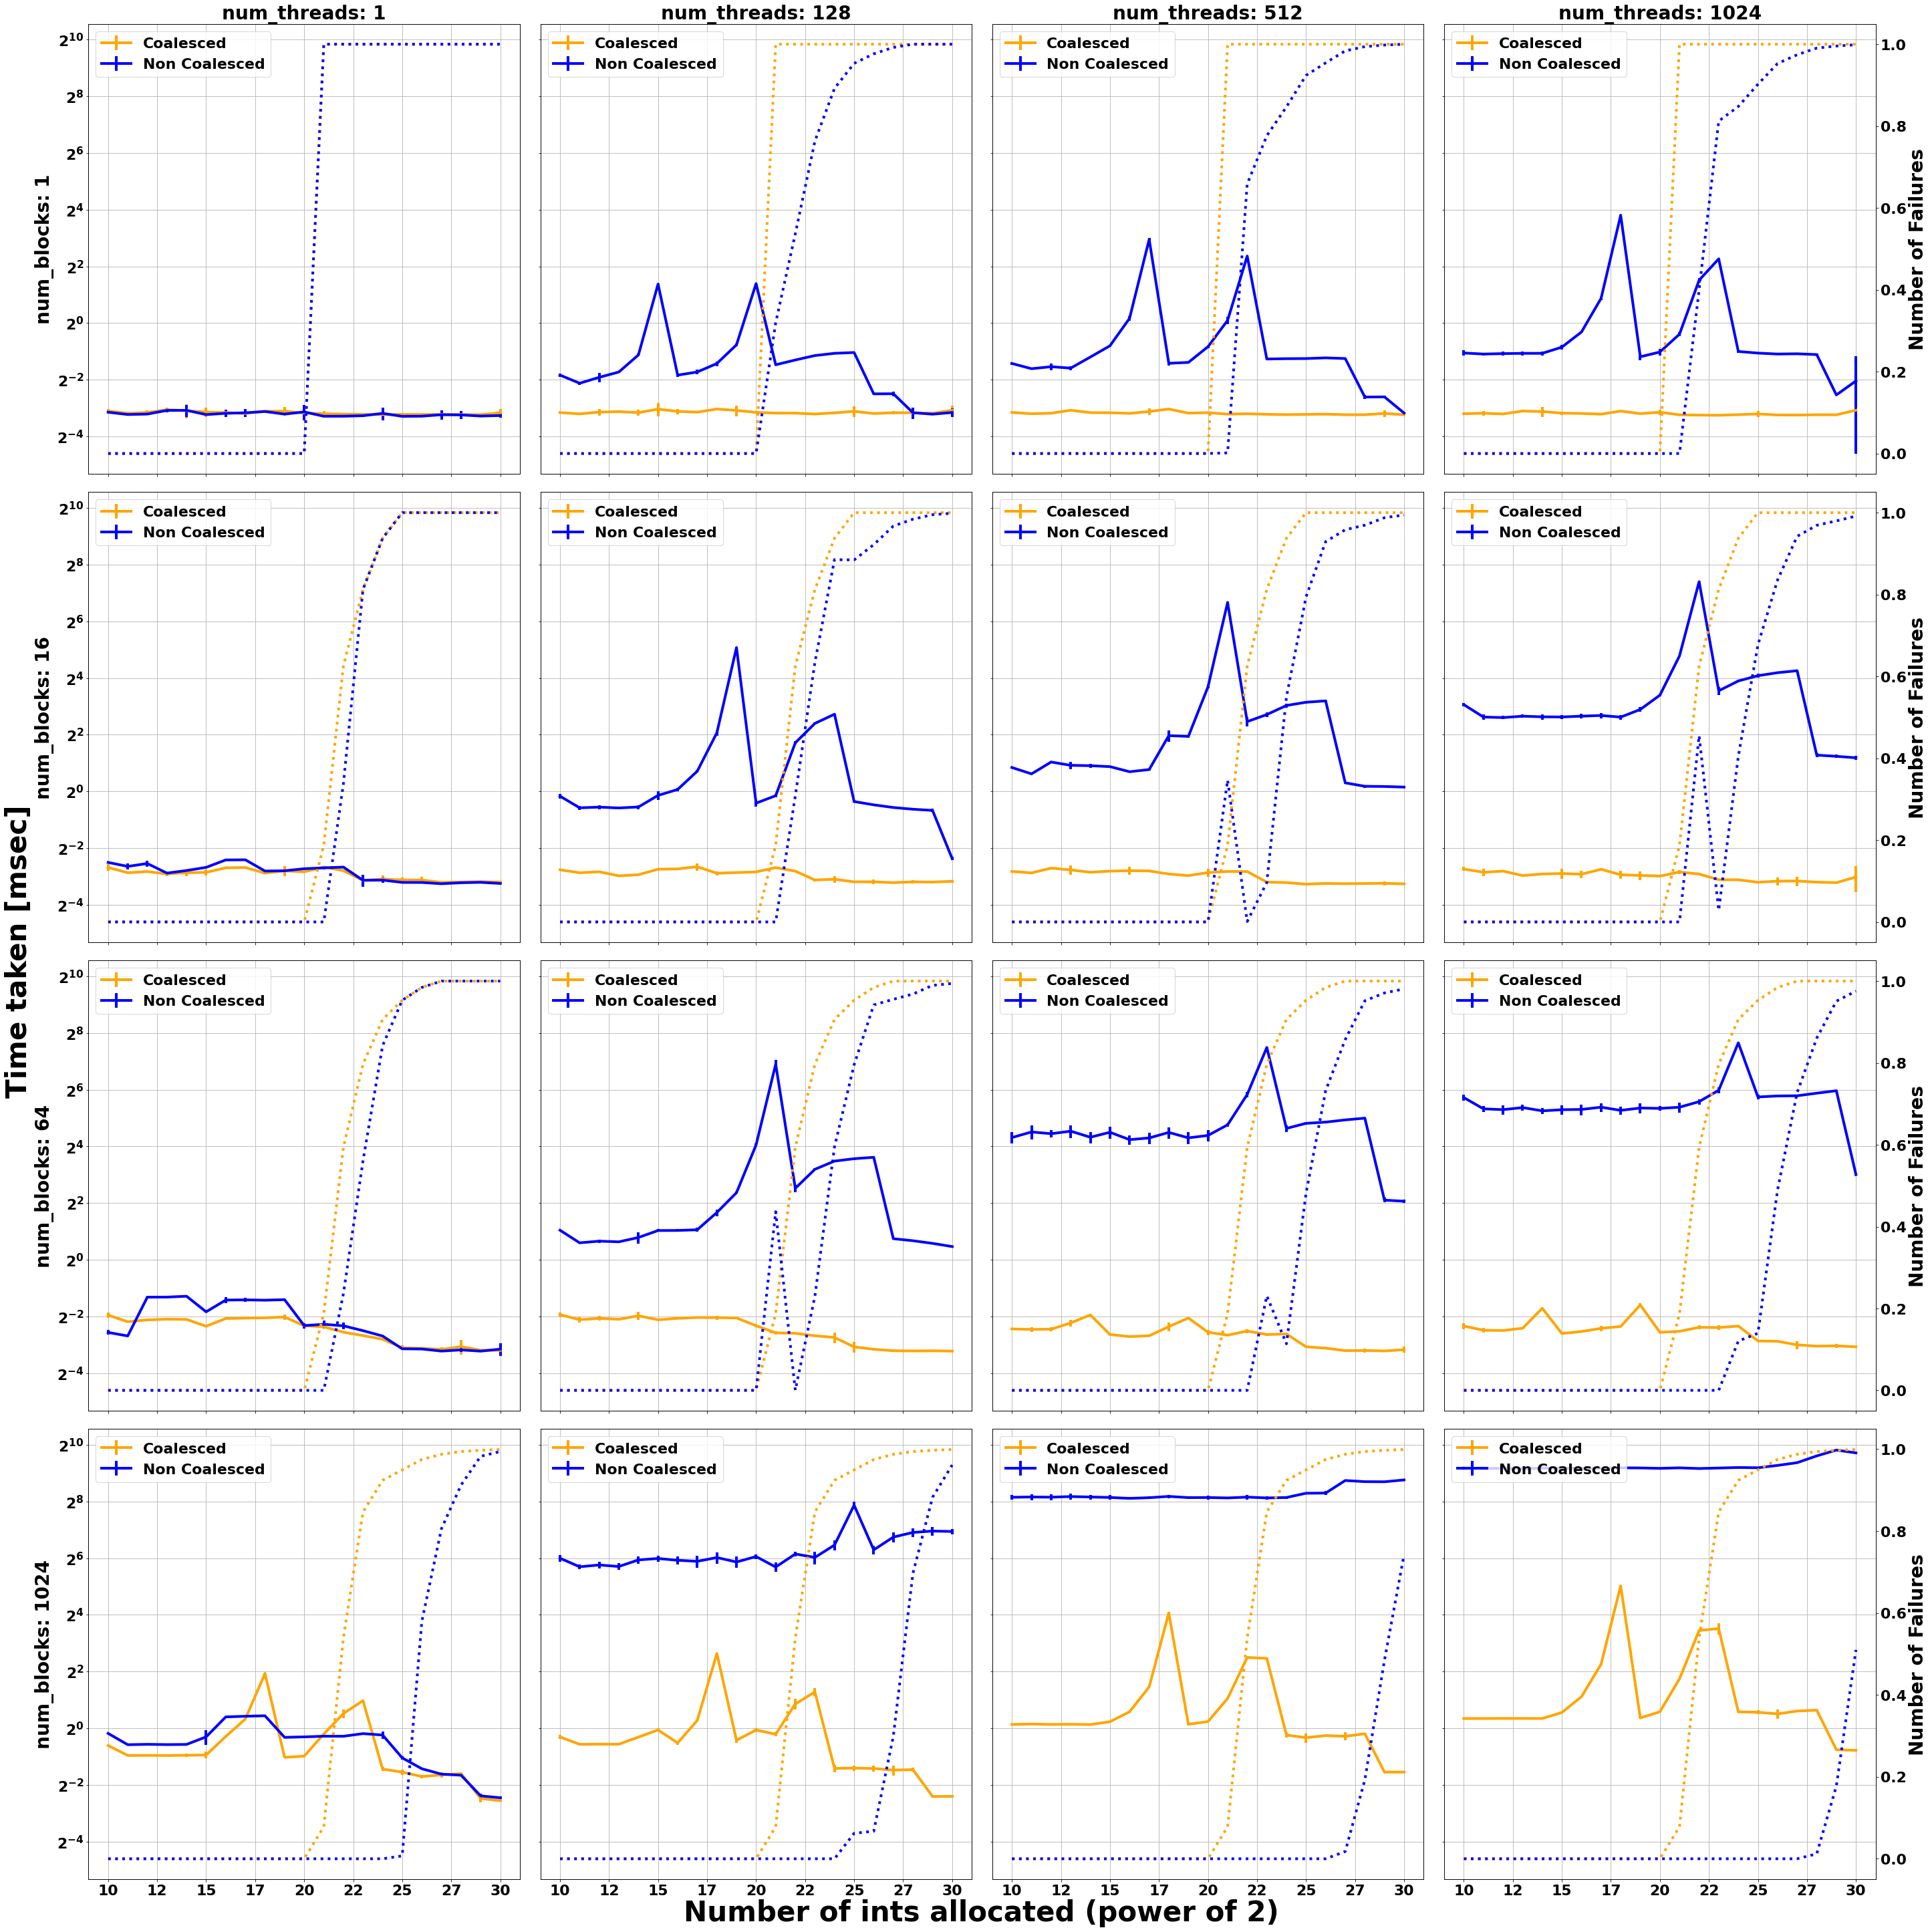

In [93]:
def plot(c, nc, x, x_name, y, y_name, title):
    font = {'weight' : 'bold',
            'size'   : 22}
    matplotlib.rc('font', **font)
    fontdict = {'fontsize': 28,
                'fontweight': 'bold'}
    fig, axs = plt.subplots(len(y), len(x), sharey=True, sharex=True, figsize=(40, 40))
    for j, val_x in enumerate(x):
        for i, val_y in enumerate(y):
            axs[i, j].grid(True)
            axs[i, j].set_yscale('log', base=2)
        axs[0, j].set_title(x_name + ": " + str(val_x), fontdict=fontdict)
    
    for ax, row in zip(axs[:,0], y):
        ax.set_ylabel(y_name + ": " + str(row), fontdict=fontdict)
    
    for j, val_x in enumerate(x):
        for i, val_y in enumerate(y):
            cred = c.loc[(c[x_name] == val_x) & (c[y_name] == val_y)]
            ncred = nc.loc[(nc[x_name] == val_x) & (nc[y_name] == val_y)]
            axs[i, j].errorbar(list(c['ints'].unique()), cred['time_mean'], yerr=cred['time_std'], label='Coalesced', ls='-', lw=4, ms=20, c='orange')
            axs[i, j].errorbar(list(c['ints'].unique()), ncred['time_mean'], yerr=ncred['time_std'], label='Non Coalesced', ls='-', lw=4, ms=20, c='blue')
            axs[i, j].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            
            ax.set_ylabel(y_name + ": " + str(row), fontdict=fontdict)
            num_col = val_y
            if not BY_BLOCK:
                num_col = num_col * val_x
            elif x_name == 'num_blocks':
                num_col = val_x
            ax2 = axs[i, j].twinx()
            #ax2.set_yscale('log', base=2)
            ax2.plot(list(c['ints'].unique()), cred['alloc_failures_mean']/num_col, label='Coalesced Alloc Failures', ls=':', lw=4, ms=20, c='orange')
            ax2.plot(list(c['ints'].unique()), ncred['alloc_failures_mean']/(val_x*val_y), label='Non Coalesced Alloc Failures', ls=':', lw=4, ms=20, c='blue')
            if(j == len(x)-1):
                ax2.set_ylabel('Number of Failures', fontdict=fontdict)
            else:
                ax2.set_yticks([])
            
            
    fig.text(0.0, 0.5, 'Time taken [msec]', ha='center', va='center', rotation='vertical', fontsize=42)
    fig.text(0.5, 0.0, 'Number of ints allocated (power of 2)', ha='center', va='center', fontsize=42)
    for j in range(len(x)):
        for i in range(len(y)):
            axs[i, j].legend(loc="upper left")
    fig.align_ylabels()
    fig.tight_layout()
    plt.savefig(title+".png", dpi=60, bbox_inches='tight')
    plt.show()
plot(c, nc, threads, 'num_threads', blocks, 'num_blocks', CSV_PATH+'/results') 